In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 19.3MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 296kB 17.7MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-08 08:54:35--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-08 08:54:35--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb44b67bdb41beea6a04a6e10e0.dl.dropboxusercontent.com/cd/0/get/BKQ84K5OkgHjPruGR0rHcmQn3CmibLGVxhFcOHzYBszAD4va4CEv4RAJxv1XOv2S4SP2U9Uhh9Ur3u6cSzN64tPZmP_NwJRdM7pLOixuK_EwsOFTDIGMhCB9ylgJj_m2-m76d98QLOfa8R1n_2kycbyR/file?dl=1# [following]
--2021-03-08 08:54:35--  https://ucb44b67bdb41beea6a04a6e10e0.dl.dropboxusercontent.com/cd/0/get/BKQ84K5OkgHjPruGR0rHcmQn3CmibLGVxhFcOHzYBszAD4va4CEv4RAJxv1XOv2S

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='efficientnet_b2'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


SuggestedLRs(lr_min=0.07585775852203369, lr_steep=2.75422871709452e-06)

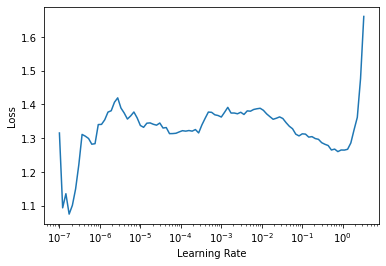

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.357119,0.967255,0.513761,0.500000,0.584906,01:04
1,1.258410,0.908249,0.516820,0.502825,0.559748,01:03


Better model found at epoch 0 with valid_loss value: 0.9672545194625854.


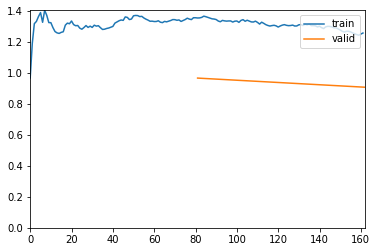

Better model found at epoch 1 with valid_loss value: 0.9082493185997009.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.245050,0.902088,0.489297,0.474684,0.471698,01:23
1,1.266705,0.893238,0.503058,0.489552,0.515723,01:22
2,1.214660,0.872284,0.503058,0.489297,0.503145,01:23
3,1.162874,0.865342,0.507645,0.494286,0.544025,01:23
4,1.110515,0.860514,0.507645,0.493789,0.500000,01:23
5,1.084242,0.831909,0.516820,0.502762,0.572327,01:22
6,1.066782,0.817136,0.544343,0.532468,0.515723,01:22
7,1.008756,0.800451,0.533639,0.519878,0.534591,01:23
8,1.007306,0.800770,0.527523,0.512748,0.569182,01:23
9,1.023652,0.787231,0.547401,0.536184,0.512579,01:22


Better model found at epoch 0 with valid_loss value: 0.9020875692367554.


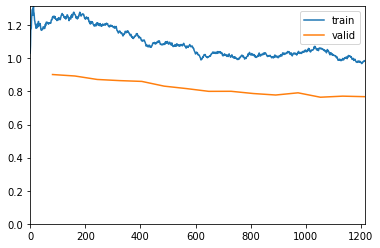

Better model found at epoch 1 with valid_loss value: 0.8932383060455322.
Better model found at epoch 2 with valid_loss value: 0.8722842931747437.
Better model found at epoch 3 with valid_loss value: 0.8653420805931091.
Better model found at epoch 4 with valid_loss value: 0.8605143427848816.
Better model found at epoch 5 with valid_loss value: 0.8319093585014343.
Better model found at epoch 6 with valid_loss value: 0.8171360492706299.
Better model found at epoch 7 with valid_loss value: 0.8004509806632996.
Better model found at epoch 9 with valid_loss value: 0.787230908870697.
Better model found at epoch 10 with valid_loss value: 0.7782604694366455.
Better model found at epoch 12 with valid_loss value: 0.7649522423744202.


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

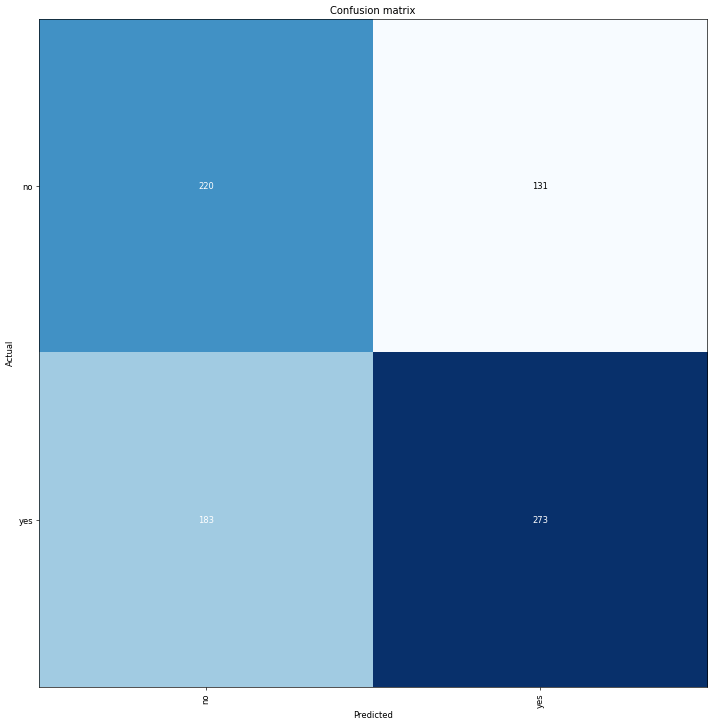

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6109045743942261.


(#4) [0.7203680276870728,0.6109045743942261,0.6757425742574258,0.5986842105263158]

## Faltten

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.298734,0.884565,0.611621,0.580808,0.723270,01:04
1,1.007685,0.810198,0.585627,0.566952,0.625786,01:03


Better model found at epoch 0 with valid_loss value: 0.8845648169517517.


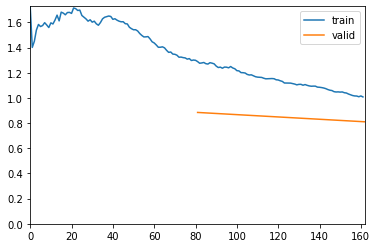

Better model found at epoch 1 with valid_loss value: 0.8101977705955505.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.00019054606673307717)

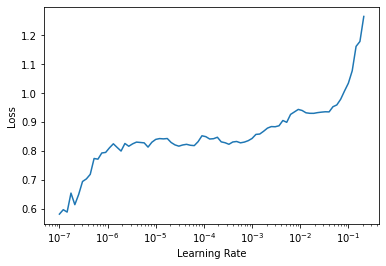

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.136673,30.647039,0.521407,0.510121,0.396226,01:22
1,1.047666,19.494793,0.515290,0.555556,0.015723,01:21
2,1.082675,1.526889,0.493884,0.465608,0.276730,01:22
3,0.962807,1.435863,0.535168,0.555556,0.220126,01:21
4,1.011032,0.817399,0.489297,0.487578,0.987421,01:22
5,0.998467,0.958498,0.486239,0.486239,1.000000,01:22
6,1.012813,2.461355,0.513761,0.000000,0.000000,01:22
7,1.009122,0.834463,0.486239,0.486239,1.000000,01:22


Better model found at epoch 0 with valid_loss value: 30.64703941345215.


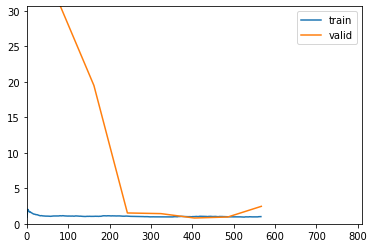

Better model found at epoch 1 with valid_loss value: 19.494792938232422.
Better model found at epoch 2 with valid_loss value: 1.526889443397522.
Better model found at epoch 3 with valid_loss value: 1.4358627796173096.
Better model found at epoch 4 with valid_loss value: 0.8173986673355103.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 4: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

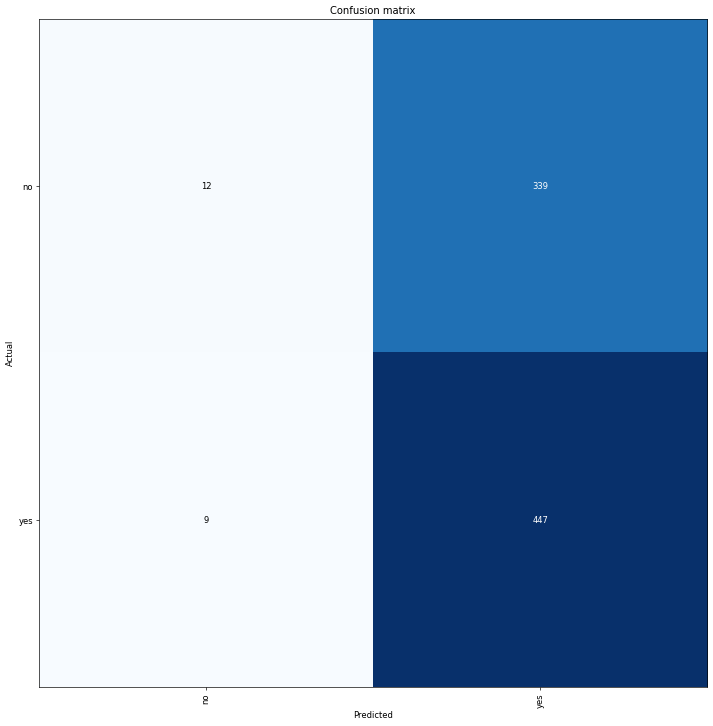

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5687732100486755.


(#4) [0.7701132297515869,0.5687732100486755,0.5687022900763359,0.9802631578947368]

## LabelSmoothing

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=5.754399353463668e-06)

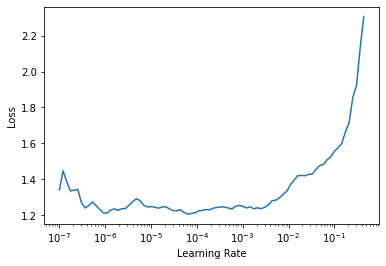

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.190759,1.054941,0.539755,0.526984,0.522013,01:03
1,1.089139,0.819341,0.567278,0.545455,0.660377,01:03


Better model found at epoch 0 with valid_loss value: 1.0549410581588745.


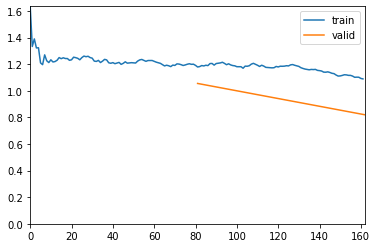

Better model found at epoch 1 with valid_loss value: 0.8193407654762268.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.780543,0.707249,0.603976,0.587537,0.622642,01:22
1,0.752693,0.707289,0.585627,0.571429,0.591195,01:22
2,0.710147,0.657517,0.626911,0.629371,0.566038,01:22
3,0.702069,0.677600,0.579511,0.551069,0.729560,01:22
4,0.668445,0.657757,0.636086,0.612360,0.685535,01:21
5,0.652159,0.633481,0.652905,0.635015,0.672956,01:22
6,0.629037,0.652742,0.645260,0.628743,0.660377,01:22
7,0.623195,0.647381,0.640673,0.613699,0.704403,01:22
8,0.616727,0.627118,0.668196,0.672355,0.619497,01:22
9,0.603215,0.639832,0.646789,0.646465,0.603774,01:22


Better model found at epoch 0 with valid_loss value: 0.7072491645812988.


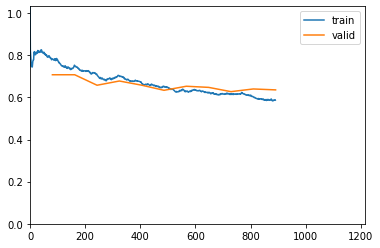

Better model found at epoch 2 with valid_loss value: 0.6575174331665039.
Better model found at epoch 5 with valid_loss value: 0.6334813237190247.
Better model found at epoch 8 with valid_loss value: 0.6271175742149353.
No improvement since epoch 8: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

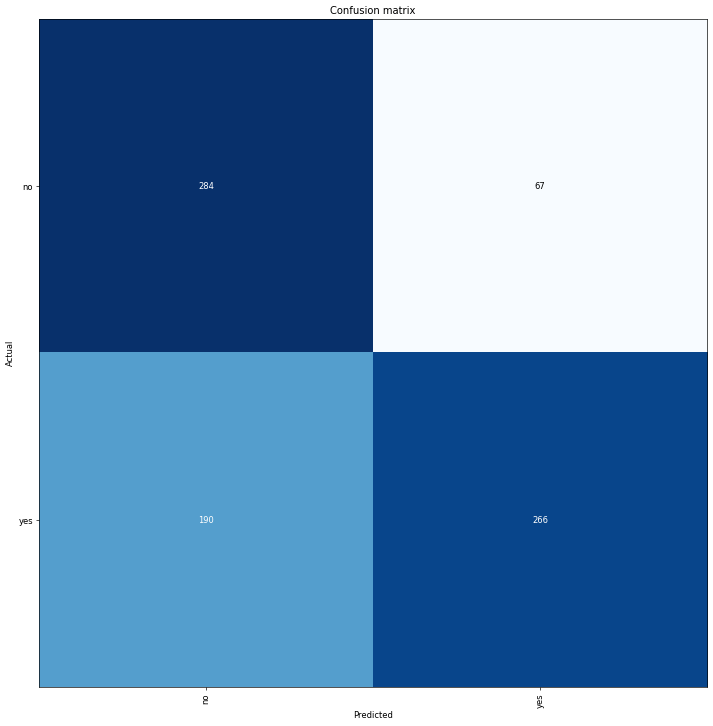

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6815365552902222.


(#4) [0.6151940822601318,0.6815365552902222,0.7987987987987988,0.5833333333333334]

## MixUp

In [11]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.244859,0.915351,0.607034,0.598071,0.584906,01:04
1,1.136777,0.749407,0.555046,0.538462,0.594340,01:04


Better model found at epoch 0 with valid_loss value: 0.915351152420044.


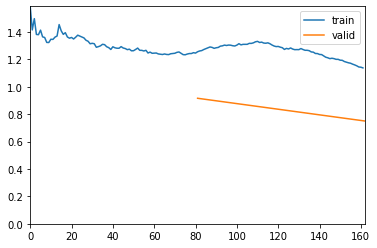

Better model found at epoch 1 with valid_loss value: 0.7494066953659058.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.800219,0.687044,0.600917,0.593443,0.569182,01:23
1,0.763761,0.673666,0.619266,0.608833,0.606918,01:23
2,0.732495,0.664263,0.607034,0.605536,0.550314,01:23
3,0.702760,0.670860,0.585627,0.558603,0.704403,01:23
4,0.687365,0.651527,0.611621,0.599379,0.606918,01:23
5,0.672671,0.641235,0.622324,0.659193,0.462264,01:23
6,0.667922,0.628179,0.649847,0.633634,0.663522,01:23
7,0.656257,0.615764,0.654434,0.671642,0.566038,01:23
8,0.649763,0.605159,0.649847,0.658363,0.581761,01:23
9,0.636445,0.621191,0.643731,0.660377,0.550314,01:23


Better model found at epoch 0 with valid_loss value: 0.6870436072349548.


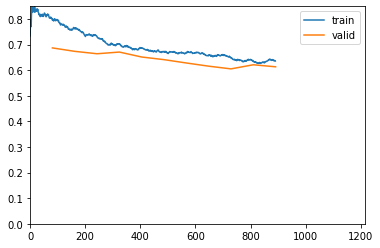

Better model found at epoch 1 with valid_loss value: 0.6736658811569214.
Better model found at epoch 2 with valid_loss value: 0.664263129234314.
Better model found at epoch 4 with valid_loss value: 0.6515267491340637.
Better model found at epoch 5 with valid_loss value: 0.6412351131439209.
Better model found at epoch 6 with valid_loss value: 0.6281793117523193.
Better model found at epoch 7 with valid_loss value: 0.6157637238502502.
Better model found at epoch 8 with valid_loss value: 0.6051585078239441.
No improvement since epoch 8: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

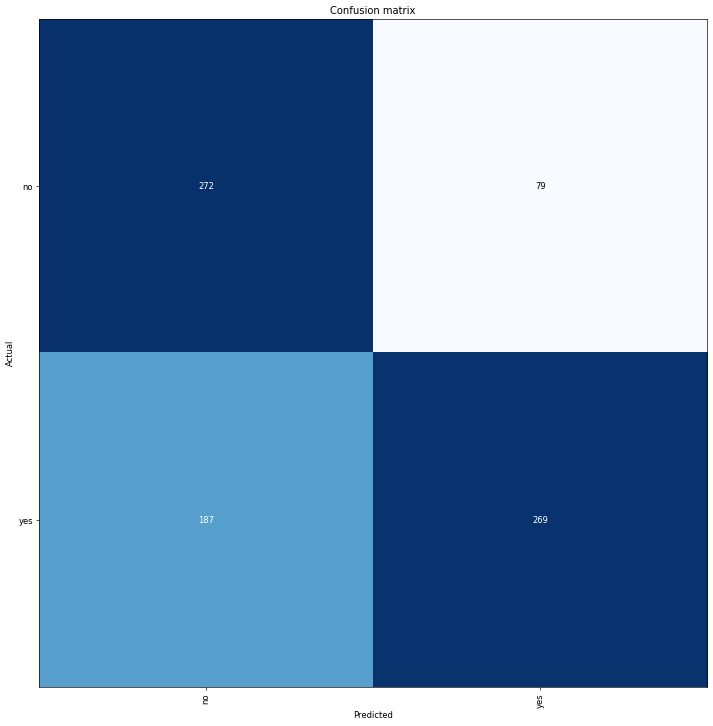

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6703841090202332.


(#4) [0.6070367097854614,0.6703841090202332,0.7729885057471264,0.5899122807017544]

## Ranger + Flat cosin Anneal

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.295860,0.959084,0.516820,0.538462,0.551020,01:05
1,1.257677,0.928250,0.522936,0.544413,0.553936,01:03


Better model found at epoch 0 with valid_loss value: 0.9590838551521301.


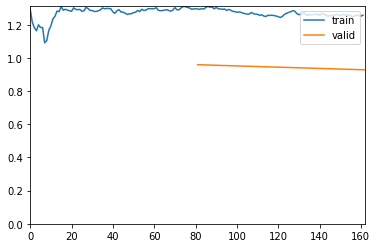

Better model found at epoch 1 with valid_loss value: 0.9282504916191101.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=6.309573450380412e-07)

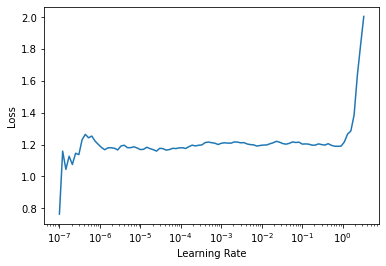

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.186058,0.817054,0.584098,0.626335,0.513120,01:20
1,1.052472,0.741807,0.594801,0.623418,0.574344,01:21
2,0.898196,0.697568,0.620795,0.667845,0.551020,01:21
3,0.788294,0.637267,0.662080,0.681548,0.667638,01:22
4,0.720856,0.623355,0.660550,0.703704,0.609329,01:21
5,0.665964,0.637680,0.660550,0.733591,0.553936,01:21
6,0.622793,0.614220,0.666667,0.711864,0.612245,01:21
7,0.603889,0.610002,0.663609,0.746988,0.542274,01:21
8,0.596029,0.616839,0.677370,0.772727,0.545190,01:21
9,0.588560,0.615137,0.662080,0.747967,0.536443,01:21


Better model found at epoch 0 with valid_loss value: 0.8170536756515503.


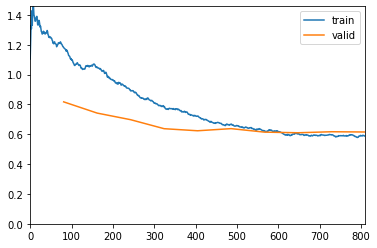

Better model found at epoch 1 with valid_loss value: 0.7418069839477539.
Better model found at epoch 2 with valid_loss value: 0.6975682377815247.
Better model found at epoch 3 with valid_loss value: 0.6372672319412231.
Better model found at epoch 4 with valid_loss value: 0.6233553290367126.
Better model found at epoch 6 with valid_loss value: 0.6142202615737915.
Better model found at epoch 7 with valid_loss value: 0.6100020408630371.


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7087979912757874.


(#4) [0.5678227543830872,0.7087979912757874,0.8463949843260188,0.5921052631578947]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.309604,0.958678,0.500000,0.525000,0.489796,01:03
1,1.259439,0.927524,0.521407,0.544910,0.530612,01:03


Better model found at epoch 0 with valid_loss value: 0.9586781859397888.


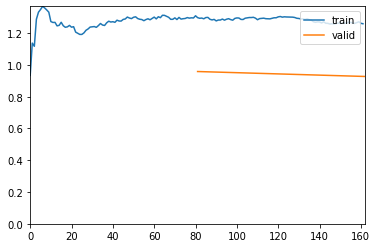

Better model found at epoch 1 with valid_loss value: 0.9275242686271667.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=3.981071586167673e-06)

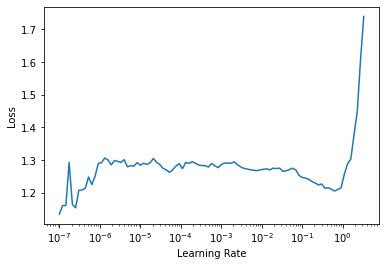

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.162405,0.775618,0.576453,0.589674,0.632653,01:21
1,1.026165,0.723476,0.605505,0.644068,0.553936,01:21
2,0.886423,0.683013,0.620795,0.640118,0.632653,01:21
3,0.806878,0.665802,0.648318,0.692833,0.591837,01:21
4,0.728671,0.647906,0.671254,0.706452,0.638484,01:21
5,0.690906,0.633512,0.665138,0.726277,0.580175,01:22
6,0.645433,0.632036,0.675841,0.743494,0.583090,01:21
7,0.630357,0.623443,0.654434,0.712727,0.571429,01:21
8,0.619924,0.615247,0.666667,0.719298,0.597668,01:22
9,0.617997,0.623550,0.663609,0.751020,0.536443,01:22


Better model found at epoch 0 with valid_loss value: 0.7756175398826599.


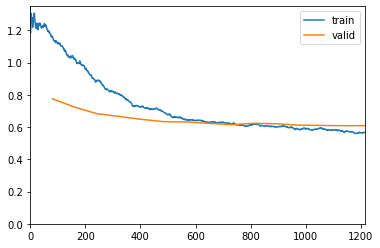

Better model found at epoch 1 with valid_loss value: 0.7234756350517273.
Better model found at epoch 2 with valid_loss value: 0.6830127239227295.
Better model found at epoch 3 with valid_loss value: 0.6658024191856384.
Better model found at epoch 4 with valid_loss value: 0.647905707359314.
Better model found at epoch 5 with valid_loss value: 0.6335119605064392.
Better model found at epoch 6 with valid_loss value: 0.6320356726646423.
Better model found at epoch 7 with valid_loss value: 0.6234433650970459.
Better model found at epoch 8 with valid_loss value: 0.6152471899986267.
Better model found at epoch 11 with valid_loss value: 0.6121875643730164.
Better model found at epoch 12 with valid_loss value: 0.6105141043663025.
Better model found at epoch 13 with valid_loss value: 0.6086886525154114.


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7224287390708923.


(#4) [0.5804569721221924,0.7224287390708923,0.8625,0.6052631578947368]

## Ranger +Flat + Label + MixUp

In [12]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.235391,0.979791,0.496942,0.518519,0.571429,00:34
1,1.238968,0.944273,0.501529,0.523035,0.562682,00:33


Better model found at epoch 0 with valid_loss value: 0.9797911047935486.


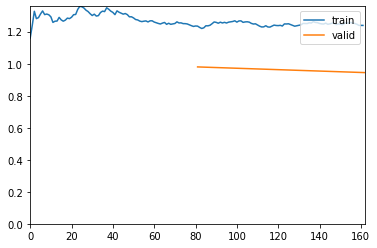

Better model found at epoch 1 with valid_loss value: 0.9442726373672485.


In [13]:
learn.fit_flat_cos(2,lr=1e-3)

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.168763,0.815185,0.533639,0.559375,0.521866,00:40
1,1.058258,0.760132,0.588685,0.629371,0.524781,00:40
2,0.948166,0.698606,0.617737,0.632479,0.647230,00:40
3,0.848077,0.675290,0.623853,0.667820,0.562682,00:40
4,0.763309,0.660666,0.611621,0.658363,0.539359,00:40
5,0.726630,0.650128,0.639144,0.655977,0.655977,00:39
6,0.694988,0.636017,0.652905,0.694631,0.603499,00:39
7,0.673758,0.632131,0.640673,0.682432,0.588921,00:39
8,0.649988,0.638161,0.642202,0.722449,0.516035,00:40
9,0.655449,0.628241,0.649847,0.705036,0.571429,00:40


Better model found at epoch 0 with valid_loss value: 0.8151847720146179.


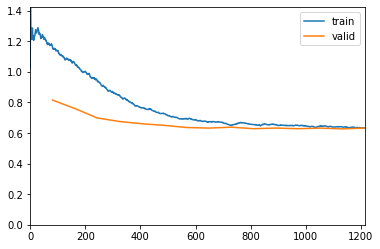

Better model found at epoch 1 with valid_loss value: 0.760132372379303.
Better model found at epoch 2 with valid_loss value: 0.6986061930656433.
Better model found at epoch 3 with valid_loss value: 0.6752899885177612.
Better model found at epoch 4 with valid_loss value: 0.660666286945343.
Better model found at epoch 5 with valid_loss value: 0.6501275897026062.
Better model found at epoch 6 with valid_loss value: 0.6360174417495728.
Better model found at epoch 7 with valid_loss value: 0.6321309804916382.
Better model found at epoch 9 with valid_loss value: 0.6282414197921753.
Better model found at epoch 11 with valid_loss value: 0.6280664801597595.
Better model found at epoch 13 with valid_loss value: 0.6271320581436157.


In [15]:
learn.fit_flat_cos(15,lr=1e-2)

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

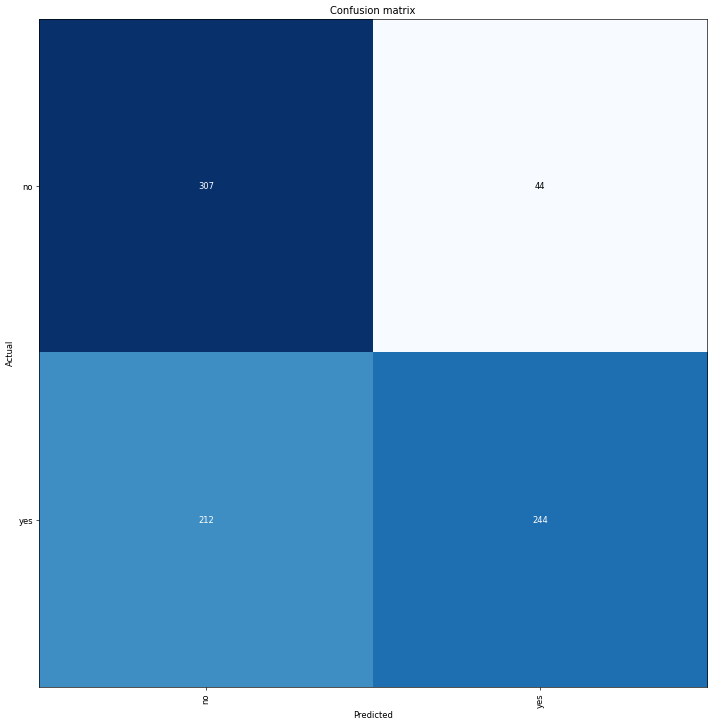

In [17]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6827757358551025.


(#4) [0.608871579170227,0.6827757358551025,0.8472222222222222,0.5350877192982456]

## Ranger + Flat + MixUp

In [19]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [20]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.382166,0.986356,0.521407,0.535545,0.658892,00:36
1,1.375039,0.950395,0.529052,0.541176,0.670554,00:35


Better model found at epoch 0 with valid_loss value: 0.986355721950531.


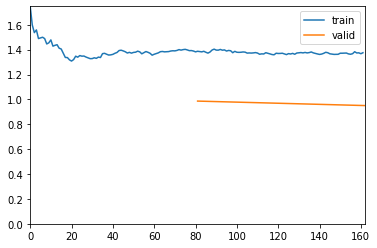

Better model found at epoch 1 with valid_loss value: 0.9503947496414185.


In [21]:
learn.fit_flat_cos(2,lr=1e-3)

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.243999,0.824758,0.568807,0.586895,0.600583,00:42
1,1.084687,0.731907,0.585627,0.608434,0.588921,00:42
2,0.941663,0.689722,0.590214,0.627119,0.539359,00:42
3,0.851856,0.681686,0.600917,0.661417,0.489796,00:42
4,0.776576,0.657201,0.608563,0.683544,0.472303,00:43
5,0.708568,0.623647,0.622324,0.688976,0.510204,00:42
6,0.687320,0.622832,0.633027,0.710204,0.507289,00:43
7,0.670620,0.613091,0.660550,0.723247,0.571429,00:43
8,0.652613,0.606862,0.675841,0.743494,0.583090,00:43
9,0.640025,0.614535,0.666667,0.772926,0.516035,00:42


Better model found at epoch 0 with valid_loss value: 0.8247575163841248.


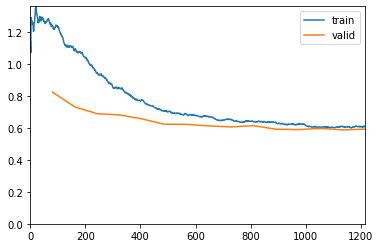

Better model found at epoch 1 with valid_loss value: 0.7319074273109436.
Better model found at epoch 2 with valid_loss value: 0.6897215247154236.
Better model found at epoch 3 with valid_loss value: 0.6816858053207397.
Better model found at epoch 4 with valid_loss value: 0.6572009921073914.
Better model found at epoch 5 with valid_loss value: 0.6236469149589539.
Better model found at epoch 6 with valid_loss value: 0.6228315830230713.
Better model found at epoch 7 with valid_loss value: 0.6130907535552979.
Better model found at epoch 8 with valid_loss value: 0.6068621277809143.
Better model found at epoch 10 with valid_loss value: 0.5925569534301758.
Better model found at epoch 11 with valid_loss value: 0.5897250771522522.
Better model found at epoch 13 with valid_loss value: 0.5880071520805359.


In [23]:
learn.fit_flat_cos(15,lr=1e-2)

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [25]:
learn.dls = dlsTest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7125154733657837.


(#4) [0.5532232522964478,0.7125154733657837,0.8393939393939394,0.6074561403508771]

## Ranger + MixUp

In [27]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [28]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.334013,0.935640,0.525994,0.538824,0.667638,00:35
1,1.251537,0.859806,0.551988,0.565445,0.629738,00:35


Better model found at epoch 0 with valid_loss value: 0.9356400370597839.


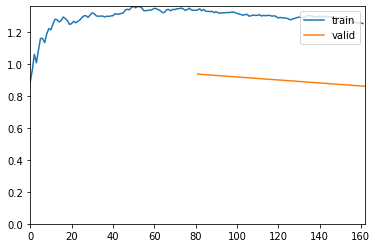

Better model found at epoch 1 with valid_loss value: 0.8598060011863708.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.221210,0.871638,0.538226,0.552163,0.632653,00:42
1,1.228643,0.842320,0.550459,0.557647,0.690962,00:42
2,1.204659,0.835206,0.541284,0.560563,0.580175,00:43
3,1.153063,0.809295,0.561162,0.575676,0.620991,00:42
4,1.102318,0.806959,0.550459,0.567867,0.597668,00:42
5,1.086371,0.809665,0.535168,0.554622,0.577259,00:42
6,1.091363,0.767072,0.582569,0.606707,0.580175,00:42
7,1.056143,0.753393,0.585627,0.599448,0.632653,00:42
8,1.067563,0.760877,0.567278,0.589286,0.577259,00:42
9,1.038989,0.762033,0.562691,0.583090,0.583090,00:42


Better model found at epoch 0 with valid_loss value: 0.8716384172439575.


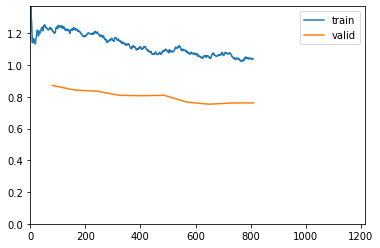

Better model found at epoch 1 with valid_loss value: 0.8423201441764832.
Better model found at epoch 2 with valid_loss value: 0.8352058529853821.
Better model found at epoch 3 with valid_loss value: 0.8092954754829407.
Better model found at epoch 4 with valid_loss value: 0.8069590330123901.
Better model found at epoch 6 with valid_loss value: 0.7670724391937256.
Better model found at epoch 7 with valid_loss value: 0.7533934116363525.
No improvement since epoch 7: early stopping


In [29]:
learn.fine_tune(15,freeze_epochs=2)

In [30]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [31]:
learn.dls = dlsTest

In [32]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5117719769477844.


(#4) [0.8235401511192322,0.5117719769477844,0.5707762557077626,0.5482456140350878]

## Faltten + MixUp

In [33]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.360674,0.836104,0.600917,0.641379,0.542274,00:35
1,0.985131,0.712312,0.619266,0.662069,0.559767,00:34


Better model found at epoch 0 with valid_loss value: 0.836104154586792.


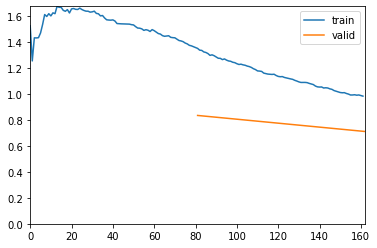

Better model found at epoch 1 with valid_loss value: 0.7123119831085205.


In [34]:
learn.fit_flat_cos(2,lr=1e-3)

In [35]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.083579,0.791186,0.504587,0.524297,0.597668,00:41
1,0.972009,4.051244,0.492355,0.587302,0.107872,00:41
2,1.106226,19.992918,0.524465,0.524465,1.000000,00:41
3,1.022855,8.691388,0.522936,0.581152,0.323615,00:41


Better model found at epoch 0 with valid_loss value: 0.7911860346794128.


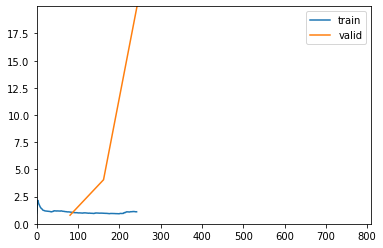

No improvement since epoch 0: early stopping


In [36]:
learn.fit_flat_cos(10,lr=1e-2)

In [37]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [38]:
learn.dls = dlsTest

In [39]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5092936754226685.


(#4) [0.7939701080322266,0.5092936754226685,0.5595238095238095,0.618421052631579]

## Ranger + Label

In [40]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [41]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.385922,0.926425,0.542813,0.564706,0.559767,00:35
1,1.331146,0.886926,0.555046,0.580745,0.545190,00:36


Better model found at epoch 0 with valid_loss value: 0.9264250993728638.


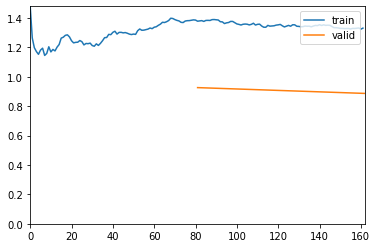

Better model found at epoch 1 with valid_loss value: 0.8869262933731079.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.241314,0.880139,0.561162,0.583333,0.571429,00:42
1,1.263502,0.880257,0.576453,0.604430,0.556851,00:42
2,1.262118,0.859198,0.579511,0.599415,0.597668,00:43
3,1.235052,0.846781,0.562691,0.588785,0.551020,00:42
4,1.178400,0.839446,0.573394,0.609589,0.518950,00:43
5,1.184554,0.814959,0.581040,0.610224,0.556851,00:42
6,1.154809,0.798925,0.594801,0.624204,0.571429,00:42
7,1.138738,0.802508,0.581040,0.621053,0.516035,00:42
8,1.128645,0.796193,0.582569,0.620690,0.524781,00:42
9,1.050576,0.779686,0.593272,0.628763,0.548105,00:42


Better model found at epoch 0 with valid_loss value: 0.8801385164260864.


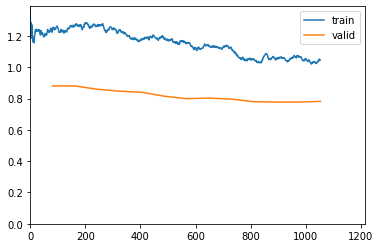

Better model found at epoch 2 with valid_loss value: 0.8591978549957275.
Better model found at epoch 3 with valid_loss value: 0.8467806577682495.
Better model found at epoch 4 with valid_loss value: 0.8394460082054138.
Better model found at epoch 5 with valid_loss value: 0.8149593472480774.
Better model found at epoch 6 with valid_loss value: 0.7989251613616943.
Better model found at epoch 8 with valid_loss value: 0.7961925268173218.
Better model found at epoch 9 with valid_loss value: 0.7796863913536072.
Better model found at epoch 10 with valid_loss value: 0.7770818471908569.
No improvement since epoch 10: early stopping


In [42]:
learn.fine_tune(15,freeze_epochs=2)

In [43]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [44]:
learn.dls = dlsTest

In [45]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5762081742286682.


(#4) [0.7740532755851746,0.5762081742286682,0.6532258064516129,0.5328947368421053]

## Faltten + Label

In [46]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.299684,0.998512,0.541284,0.579926,0.454810,00:35
1,0.955356,0.777004,0.608563,0.662921,0.516035,00:35


Better model found at epoch 0 with valid_loss value: 0.9985119104385376.


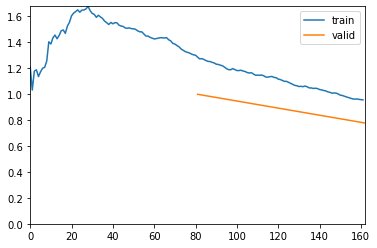

Better model found at epoch 1 with valid_loss value: 0.7770038843154907.


In [47]:
learn.fit_flat_cos(2,lr=1e-3)

In [48]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.9054607491852948e-06)

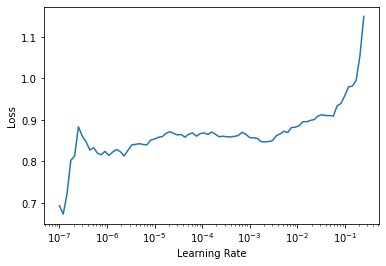

In [49]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.033823,166.106247,0.481651,0.506211,0.475219,00:41
1,1.023117,7.908604,0.492355,0.560440,0.148688,00:41
2,1.055507,2.252136,0.524465,0.524465,1.000000,00:41
3,1.044360,1.247150,0.475535,0.500000,0.029155,00:41
4,1.249269,371.891876,0.503058,0.520737,0.658892,00:41
5,1.118605,1.025459,0.524465,0.524465,1.000000,00:41
6,1.059393,0.716467,0.512232,0.534884,0.536443,00:41
7,0.992336,1.709563,0.518349,0.521605,0.985423,00:41
8,0.901832,5.417171,0.483180,0.600000,0.043732,00:41
9,0.866286,0.984388,0.477064,0.516129,0.046647,00:41


Better model found at epoch 0 with valid_loss value: 166.1062469482422.


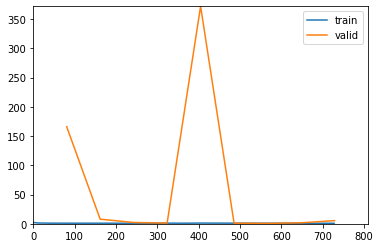

Better model found at epoch 1 with valid_loss value: 7.908604145050049.
Better model found at epoch 2 with valid_loss value: 2.2521355152130127.
Better model found at epoch 3 with valid_loss value: 1.2471504211425781.
Better model found at epoch 5 with valid_loss value: 1.025458574295044.
Better model found at epoch 6 with valid_loss value: 0.7164673209190369.
No improvement since epoch 6: early stopping


In [50]:
learn.fit_flat_cos(10,lr=1e-2)

In [51]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [52]:
learn.dls = dlsTest

In [53]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5030978918075562.


(#4) [0.7044048309326172,0.5030978918075562,0.5635103926096998,0.5350877192982456]

## Label + MixUp

In [54]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.253000,1.034361,0.542813,0.559459,0.603499,00:35
1,1.049224,0.773923,0.561162,0.572917,0.641399,00:35


Better model found at epoch 0 with valid_loss value: 1.0343610048294067.


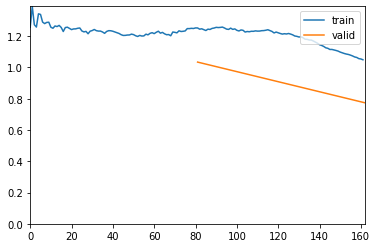

Better model found at epoch 1 with valid_loss value: 0.7739232778549194.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.782995,0.704657,0.577982,0.605678,0.559767,00:42
1,0.740730,0.690020,0.596330,0.641577,0.521866,00:42
2,0.723704,0.721890,0.565749,0.656085,0.361516,00:41
3,0.701341,0.675067,0.596330,0.632997,0.548105,00:42
4,0.691847,0.658554,0.622324,0.631148,0.673469,00:41
5,0.680403,0.656410,0.608563,0.665399,0.510204,00:42
6,0.670529,0.667810,0.590214,0.653061,0.466472,00:42
7,0.660847,0.653721,0.619266,0.671533,0.536443,00:41
8,0.658103,0.661091,0.631498,0.719828,0.486880,00:42
9,0.647616,0.649258,0.651376,0.698962,0.588921,00:42


Better model found at epoch 0 with valid_loss value: 0.7046568393707275.


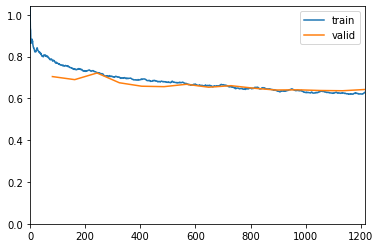

Better model found at epoch 1 with valid_loss value: 0.6900198459625244.
Better model found at epoch 3 with valid_loss value: 0.6750668287277222.
Better model found at epoch 4 with valid_loss value: 0.6585536003112793.
Better model found at epoch 5 with valid_loss value: 0.6564100384712219.
Better model found at epoch 7 with valid_loss value: 0.6537205576896667.
Better model found at epoch 9 with valid_loss value: 0.6492582559585571.
Better model found at epoch 10 with valid_loss value: 0.6404141187667847.
Better model found at epoch 12 with valid_loss value: 0.6380922198295593.
Better model found at epoch 13 with valid_loss value: 0.6368534564971924.


In [55]:
learn.fine_tune(15,freeze_epochs=2)

In [56]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [57]:
learn.dls = dlsTest

In [58]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6666666865348816.


(#4) [0.6203804016113281,0.6666666865348816,0.7824773413897281,0.5679824561403509]